In [6]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
import scqubits as scq

Le but est de simuler avec différentes méthodes le hamiltonien suivant : 

$$\hat{H} = \left[ 4E_{C_T}\hat{n}_T^2 - E_J \cos(\hat{\varphi}_T) \right] \otimes \mathbb{I} 
+ \mathbb{I} \otimes \left( \hbar\omega(\hat{a}^\dagger\hat{a}) + \frac{1}{2} \right)
- 4E_{coupling} \hat{n}_T \otimes \left(i n_{ZPF}(\hat{a}^\dagger - \hat{a}) \right)$$

## Résolution SCQUBITS

In [7]:
def get_eigen_sc(
    EJ=30.02,
    EC_T=1.2,
    EC_R=0.01,
    EL_R=0.5,
    E_coupling=0.1,
    n_cut=31,
    osc_cut=10,
    N_eigen=3,
):
    omega = np.sqrt(8 * EC_R * EL_R)

    n_zpf = (EL_R / (32 * EC_R))**0.25

    transmon = scq.Transmon(EJ=EJ, EC=EC_T, ng=0.0, ncut=n_cut)

    oscillator = scq.Oscillator(E_osc=omega, truncated_dim=osc_cut)

    hilbert_space = scq.HilbertSpace([transmon, oscillator])

    n_T = transmon.n_operator()

    a = oscillator.annihilation_operator()
    adag = oscillator.creation_operator()

    n_R = n_zpf * 1j * (adag - a)

    hilbert_space.add_interaction(
        g=-4 * E_coupling, op1=(transmon.n_operator, transmon), op2=(n_R, oscillator)
    )


    vals = hilbert_space.eigenvals(evals_count=N_eigen + 1)
    vals = vals - vals[0]

    return vals[1:]

## Résolution qutip

In [8]:
def Hamiltonian_qutip(
    EJ=30.02,
    EC_T=1.2,
    EC_R=0.01,
    EL_R=0.5,
    E_coupling=0.1,
    n_cut=31,
    osc_cut=10,
):
    omega = np.sqrt(8 * EC_R * EL_R)
    n_zpf = (EL_R / (32*EC_R))**0.25

    dim = 2 * n_cut + 1
    n_list = np.arange(-n_cut, n_cut + 1)
    n_op = qt.Qobj(np.diag(n_list))

    op_couple = qt.tunneling(dim, 1)

    H_T = 4 * EC_T * n_op**2 - 0.5 * EJ * op_couple

    a = qt.destroy(osc_cut)
    H_R = omega * a.dag() * a
    n_R = n_zpf * 1j * (a.dag() - a)

    I_T = qt.qeye(dim)
    I_R = qt.qeye(osc_cut)

    return (
        qt.tensor(H_T, I_R)
        + qt.tensor(I_T, H_R)
        - 4 * E_coupling * qt.tensor(n_op, n_R)
    )

In [9]:
def get_eigen_qutip(
    EJ=30.02,
    EC_T=1.2,
    EC_R=0.01,
    EL_R=0.5,
    E_coupling=0.1,
    n_cut=31,
    osc_cut=10,
    N_eigen=3,
):
    Hamiltonian = Hamiltonian_qutip(EJ, EC_T, EC_R, EL_R, E_coupling, n_cut, osc_cut)
    evals = Hamiltonian.eigenenergies()
    vals = evals - evals[0]

    return vals[1 : N_eigen + 1]

## Résolution numpy

In [10]:
def Hamiltonian_numpy(
    EJ=30.02,
    EC_T=1.2,
    EC_R=0.01,
    EL_R=0.5,
    E_coupling=0.1,
    n_cut=31,
    osc_cut=10,
):
    diag = [4 * EC_T * i**2 for i in range(-n_cut, n_cut + 1)]
    diag_off = [-EJ / 2 for i in range(-n_cut, n_cut)]
    diag_on = [-EJ / 2 for i in range(-n_cut, n_cut)]
    H_T = np.diag(diag, k=0) + np.diag(diag_on, k=1) + np.diag(diag_off, k=-1)
    I_T = np.eye(2 * n_cut + 1)

    omega = np.sqrt(8 * EL_R * EC_R)
    n_zpf = (EL_R / (32 * EC_R)) ** 0.25
    a = np.zeros((osc_cut, osc_cut))
    for i in range(osc_cut - 1):
        a[i][i + 1] = np.sqrt(i + 1)
    a_dag = a.conj().transpose()
    H_R = omega * (a_dag @ a + 0.5 * np.eye(osc_cut))
    I_R = np.eye(osc_cut)
    n_R = n_zpf * 1j * (a_dag - a)

    H_tot = (
        np.kron(H_T, I_R)
        + np.kron(I_T, H_R)
        - 4 * E_coupling * np.kron(np.diag(np.arange(-n_cut, n_cut + 1), k=0), n_R)
    )

    return H_tot


In [25]:
def get_eigen_numpy(
    EJ=30.02,
    EC_T=1.2,
    EC_R=0.01,
    EL_R=0.5,
    E_coupling=0.1,
    n_cut=31,
    osc_cut=10,
    N_eigen=3,
):
    H = Hamiltonian_numpy(EJ, EC_T, EC_R, EL_R, E_coupling, n_cut, osc_cut)

    eigen_values_H = np.linalg.eigvalsh(H)

    energies = eigen_values_H - eigen_values_H[0]
    return energies[1 : N_eigen + 1]

In [12]:
def plot_transmon_readout(
    EJ_max,
    EC_T=1.2,
    EC_R=0.01,
    EL_R=0.5,
    E_coupling=0.1,
    n_cut=31,
    osc_cut=10,
    N_eigen=3,
):
    EJ_liste = np.linspace(0, EJ_max, 100)
    Res = np.zeros((N_eigen, 3, 100))
    i = 0
    for EJ in EJ_liste:
        E_sc = get_eigen_sc(EJ, EC_T, EC_R, EL_R, E_coupling,n_cut,osc_cut,N_eigen)
        E_qu = get_eigen_qutip(EJ, EC_T, EC_R, EL_R, E_coupling,n_cut,osc_cut,N_eigen)
        E_np = get_eigen_numpy(EJ, EC_T, EC_R, EL_R, E_coupling,n_cut,osc_cut,N_eigen)
        Res[:, :, i] = np.array([E_sc, E_qu, E_np]).T
        i += 1
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
    for i in range(N_eigen):
        ax1.plot(EJ_liste, Res[i][0][:], label=f"Niveau {i}")
        ax2.plot(EJ_liste, Res[i][1][:], label=f"Niveau {i}")
        ax3.plot(EJ_liste, Res[i][2][:], label=f"Niveau {i}")
    ax1.set(
        xlabel=r"$EJ$",
        ylabel=r"$E^{(n)}-E^{(0)}$ [GHz]",
        title="Résolution avec scqubits",
    )
    ax2.set(
        xlabel=r"$EJ$",
        ylabel=r"$E^{(n)}-E^{(0)}$ [GHz]",
        title="Résolution avec qubits",
    )
    ax3.set(
        xlabel=r"$EJ$",
        ylabel=r"$E^{(n)}-E^{(0)}$ [GHz]",
        title="Résolution avec numpy",
    )

    ax3.legend(
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
    )
    plt.tight_layout()
    plt.show()

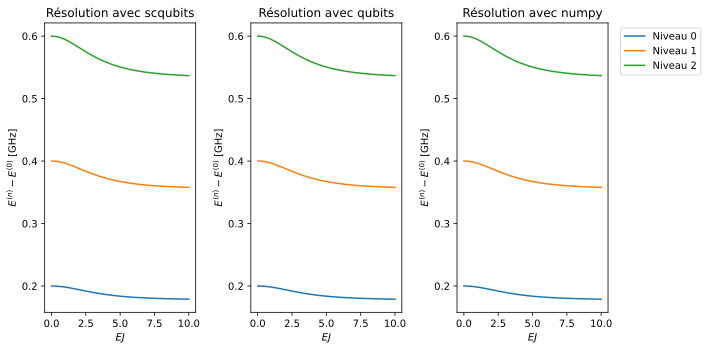

In [13]:
plot_transmon_readout(10)

## Reducing the hamiltonian related to the transmon

We are aiming to compute the coupled hamiltonian for the readout transmon for higher values of the readout cutoff. To do this, we will compute the Transmon eigenvectors alone, then inject them in the coupled hamiltonian.

We are starting from this hamiltonian : 
$$\hat{H} = \left[ 4E_{C_T}\hat{n}_T^2 - E_J \cos(\hat{\varphi}_T) \right] \otimes \mathbb{I} 
+ \mathbb{I} \otimes \left( \hbar\omega(\hat{a}^\dagger\hat{a}) + \frac{1}{2} \right)
- 4E_{coupling} \hat{n}_T \otimes \left(i n_{ZPF}(\hat{a}^\dagger - \hat{a}) \right)$$

Studying $\left[ 4E_{C_T}\hat{n}_T^2 - E_J \cos(\hat{\varphi}_T) \right]$ in the charge basis gives us the decomposition in the diagonale basis, $$\left[ 4E_{C_T}\hat{n}_T^2 - E_J \cos(\hat{\varphi}_T) \right] = \sum^{2*cutoff+1}_{i=0} \lambda_i |\psi_i \rangle \langle \psi_i| \quad \text{with} \quad |\lambda_i \rangle = \sum_{j=-cutoff}^{cutoff} c_{ij} | i \rangle$$

We will select the 4 lowest energies and extract a 4*4 matrix with them. Same for $\hat{n_t}$ that we will project on this 4 vector space.

In [14]:
def hamiltonian_transmon_numpy(
    EJ=30.02,
    EC_T=1.2,
    n_transmon = 4,
    n_cut = 500
):
    diag = [4 * EC_T * i**2 for i in range(-n_cut, n_cut + 1)]
    diag_off = [-EJ / 2 for i in range(-n_cut, n_cut)]
    diag_on = [-EJ / 2 for i in range(-n_cut, n_cut)]
    H_T = np.diag(diag, k=0) + np.diag(diag_on, k=1) + np.diag(diag_off, k=-1)
    return H_T


def hamiltonian_resonator_numpy(
    EC_R=0.01,
    EL_R=0.5,
    osc_cut=100,
):
    omega = np.sqrt(8 * EL_R * EC_R)
    n_zpf = (EL_R / (32 * EC_R)) ** 0.25
    a = np.zeros((osc_cut, osc_cut))
    for i in range(osc_cut - 1):
        a[i][i + 1] = np.sqrt(i + 1)
    a_dag = a.conj().transpose()
    H_R = omega * (a_dag @ a + 0.5 * np.eye(osc_cut))
    n_R = n_zpf * 1j * (a_dag - a)
    return H_R, n_R
    
    

In [15]:
def compute_transmon_diagonalization_basis(
    EJ=30.02,
    EC_T=1.2,
    n_transmon = 4,
    n_cut = 500
):
    H_T = hamiltonian_transmon_numpy(EJ, EC_T, n_transmon, n_cut)
    eigvals, eigvecs = np.linalg.eigh(H_T)

    n_t_charge_basis = np.diag([i for i in range(-n_cut,n_cut+1)])
    n_t_diag_basis = eigvecs.conj().T @ n_t_charge_basis @ eigvecs
    n_t_diag_basis = n_t_diag_basis[:n_transmon,:n_transmon]
    H_T_diag = np.diag(eigvals[:n_transmon])
    return H_T_diag, n_t_diag_basis, eigvecs, eigvals

In [16]:
def Hamiltonian_numpy_reduced(
    EJ=30.02,
    EC_T=1.2,
    EC_R=0.01,
    EL_R=0.5,
    E_coupling=0.1,
    n_transmon=4,
    n_cut = 500,
    osc_cut=100,
):
    H_T_diag, n_t_diag_basis, _, _ = compute_transmon_diagonalization_basis(EJ,EC_T,n_transmon,n_cut)  # noqa: E501
    I_T = np.eye(n_transmon)

    H_R, n_R = hamiltonian_resonator_numpy(EC_R,EL_R,osc_cut)
    I_R = np.eye(osc_cut)

    H_tot = (
        np.kron(H_T_diag, I_R)
        + np.kron(I_T, H_R)
        - 4 * E_coupling * np.kron(n_t_diag_basis, n_R)
    )

    return H_tot


In [17]:
def get_eigen_numpy_reduced(H,
    N_eigen = 3
):
    eigen_values_H = np.linalg.eigvalsh(H)

    energies = eigen_values_H - eigen_values_H[0]
    return energies[1 : N_eigen + 1]

In [18]:
def plot_transmon_readout_reduced(EJ_max,      
    EJ=30.02,
    EC_T=1.2,
    EC_R=0.01,
    EL_R=0.5,
    E_coupling=0.1,
    n_transmon=4,
    n_cut = 500,
    osc_cut=100,
    N_eigen=3,
):
    EJ_liste = np.linspace(0, EJ_max, 100)
    Res = np.zeros((N_eigen,2, 100))
    i = 0
    for EJ in EJ_liste:
        E_np_red = get_eigen_numpy_reduced(Hamiltonian_numpy_reduced(EJ, EC_T, EC_R, EL_R, E_coupling,n_transmon, n_cut,osc_cut),N_eigen)
        E_np = get_eigen_numpy(EJ, EC_T, EC_R, EL_R, E_coupling,31,10,N_eigen)
        Res[:, :, i] = np.array([E_np_red, E_np]).T
        i += 1
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    for i in range(N_eigen):
        ax1.plot(EJ_liste, Res[i][0][:], label=f"Niveau {i}")
        ax2.plot(EJ_liste, Res[i][1][:], label=f"Niveau {i}")
    ax1.set(
        xlabel=r"$EJ$",
        ylabel=r"$E^{(n)}-E^{(0)}$ [GHz]",
        title="Résolution réduite avec numpy",
    )
    ax2.set(
        xlabel=r"$EJ$",
        ylabel=r"$E^{(n)}-E^{(0)}$ [GHz]",
        title="Résolution avec numpy",
    )

    ax2.legend(
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
    )
    plt.tight_layout()
    plt.show()

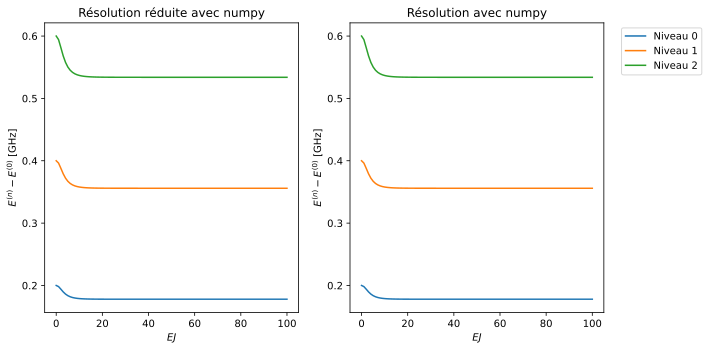

In [19]:
plot_transmon_readout_reduced(100)

## $\chi \quad$ plot

In [40]:
def get_eigenspace_transmon(
    EJ=30.02,
    EC_T=1.2,
    n_cut=31,
    ):
        diag = [4 * EC_T * i**2 for i in range(-n_cut, n_cut + 1)]
        diag_off = [-EJ / 2 for i in range(-n_cut, n_cut)]
        diag_on = [-EJ / 2 for i in range(-n_cut, n_cut)]
        H_T = np.diag(diag, k=0) + np.diag(diag_on, k=1) + np.diag(diag_off, k=-1)
        return np.linalg.eigh(H_T)
        

def get_eigenspace_numpy(
    EJ=30.02,
    EC_T=1.2,
    EC_R=0.01,
    EL_R=0.5,
    E_coupling=0.1,
    n_cut=31,
    osc_cut=10,
    N_eigen=3,
):
    H = Hamiltonian_numpy(EJ, EC_T, EC_R, EL_R, E_coupling, n_cut, osc_cut)

    eigen_values_H, eigen_vectors_H = np.linalg.eigh(H)

    return eigen_values_H, eigen_vectors_H




In [41]:
def labelling(
    EJ=30.02,
    EC_T=1.2,
    EC_R=0.01,
    EL_R=0.5,
    E_coupling=0.1,
    n_cut=31,
    osc_cut=10,
    N_eigen=3,
):
    vals_T, vecs_T = get_eigenspace_transmon(EJ, EC_T, n_cut)
    
    psi_g_q = vecs_T[:, 0] 
    psi_e_q = vecs_T[:, 1]

    psi_0_r = np.zeros(osc_cut)
    psi_0_r[0] = 1.0 
    
    psi_1_r = np.zeros(osc_cut)
    psi_1_r[1] = 1.0 

    ref_g0 = np.kron(psi_g_q, psi_0_r) 
    ref_g1 = np.kron(psi_g_q, psi_1_r) 
    ref_e0 = np.kron(psi_e_q, psi_0_r) 
    ref_e1 = np.kron(psi_e_q, psi_1_r) 

    vals_sys, vecs_sys = get_eigenspace_numpy(EJ, EC_T, EC_R, EL_R, E_coupling, n_cut, osc_cut, N_eigen)

    def find_energy_by_overlap(ref_vec, system_vals, system_vecs):
        max_overlap = -1.0
        best_idx = -1
        
        search_limit = min(len(system_vals), 20)
        
        for i in range(search_limit):
            overlap = np.abs(np.vdot(ref_vec, system_vecs[:, i]))**2
            
            if overlap > max_overlap:
                max_overlap = overlap
                best_idx = i
                
        return system_vals[best_idx]

    g_0 = find_energy_by_overlap(ref_g0, vals_sys, vecs_sys)
    g_1 = find_energy_by_overlap(ref_g1, vals_sys, vecs_sys)
    e_0 = find_energy_by_overlap(ref_e0, vals_sys, vecs_sys)
    e_1 = find_energy_by_overlap(ref_e1, vals_sys, vecs_sys)

    return g_0, g_1, e_0, e_1

In [42]:
def chi_num(
    EJ=30.02,
    EC_T=1.2,
    EC_R=0.01,
    EL_R=0.5,
    E_coupling=0.1,
    n_cut=31,
    osc_cut=10,
    N_eigen=3,
):
    E_g0, E_g1, E_e0, E_e1 = labelling(EJ, EC_T, EC_R, EL_R, E_coupling, n_cut, osc_cut, N_eigen)
    w_res_g = E_g1 - E_g0
    w_res_e = E_e1 - E_e0
    chi_num = 0.5 * (w_res_e - w_res_g)
    return chi_num

Fréquence Qubit calculée : 15.6728 GHz
Anharmonicité calculée : -1.5659 GHz
Elément de matrice <0|n|1> : 0.9028


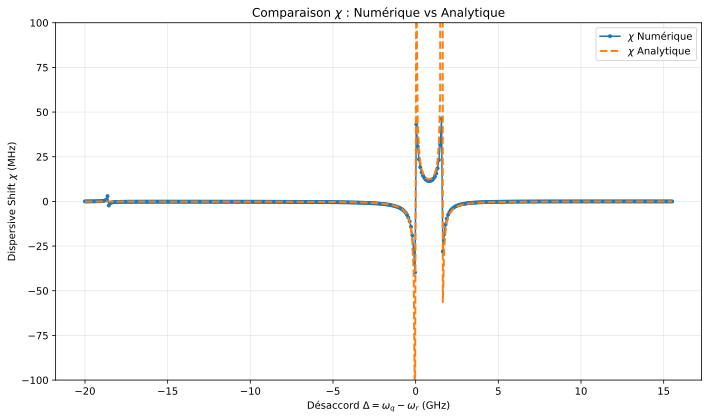

In [56]:
import numpy as np
import matplotlib.pyplot as plt

EJ_val = 30.02
EC_T_val = 1.2
EC_R_val = 0.01
E_g_val = 0.002
n_cut_val = 10
osc_cut_val = 10

vals_T, vecs_T = get_eigenspace_transmon(EJ=EJ_val, EC_T=EC_T_val, n_cut=n_cut_val)
w_q_exact = vals_T[1] - vals_T[0]
alpha_exact = (vals_T[2] - vals_T[1]) - (vals_T[1] - vals_T[0])

n_op_T = np.diag(np.arange(-n_cut_val, n_cut_val + 1))
psi_0 = vecs_T[:, 0]
psi_1 = vecs_T[:, 1]
matrix_element_n01 = np.abs(np.vdot(psi_0, n_op_T @ psi_1))

print(f"Fréquence Qubit calculée : {w_q_exact:.4f} GHz")
print(f"Anharmonicité calculée : {alpha_exact:.4f} GHz")
print(f"Elément de matrice <0|n|1> : {matrix_element_n01:.4f}")

detunings = np.linspace(-20, 20, 500)

chi_num_list = []
chi_ana_list = []
valid_detunings = []

for delta in detunings:
    w_r_current = w_q_exact - delta
    
    if w_r_current <= 0.1:
        continue
        
    valid_detunings.append(delta)
    
    EL_R_current = (w_r_current**2) / (8 * EC_R_val)
    
    n_zpf_res = (EL_R_current / (32 * EC_R_val)) ** 0.25
    g_eff = 4 * E_g_val * matrix_element_n01 * n_zpf_res
    
    g0, g1, e0, e1 = labelling(
        EJ=EJ_val, EC_T=EC_T_val, EC_R=EC_R_val, 
        EL_R=EL_R_current, E_coupling=E_g_val, 
        n_cut=n_cut_val, osc_cut=osc_cut_val
    )
    
    chi_val = 0.5 * ((e1 - e0) - (g1 - g0))
    chi_num_list.append(chi_val)
    
    if abs(delta) < 1e-4 or abs(delta + alpha_exact) < 1e-4:
        chi_ana = np.nan
    else:
        chi_ana = (g_eff**2) * (1/delta - 1/(delta + alpha_exact))
        
    chi_ana_list.append(chi_ana)

detunings_arr = np.array(valid_detunings)
chi_num_arr = np.array(chi_num_list)
chi_ana_arr = np.array(chi_ana_list)

plt.figure(figsize=(10, 6))

plt.plot(detunings_arr, chi_num_arr * 1000, 'o-', markersize=3, label=r'$\chi$ Numérique', color='tab:blue')
plt.plot(detunings_arr, chi_ana_arr * 1000, '--', linewidth=2, label=r'$\chi$ Analytique', color='tab:orange')

plt.title(r"Comparaison $\chi$ : Numérique vs Analytique")
plt.xlabel(r"Désaccord $\Delta = \omega_q - \omega_r$ (GHz)")
plt.ylabel(r"Dispersive Shift $\chi$ (MHz)") 
plt.ylim(-100, 100)

plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## Tensor network

In [20]:
import scipy.sparse.linalg as sp_linalg
import scipy.sparse as sp

In [21]:
def apply_tensor_product(axes: int, H: sp.spmatrix, V: np.ndarray) -> np.ndarray:
    """
    Apply sparse matrix H to the specified axis of tensor V

    Args:
        axes: which axis to apply the operator to (0, 1, 2, or 3)
        H: sparse matrix operator
        V: multi-dimensional array

    Returns:
        Result of applying H to axis 'axes' of V

    The following implementation works 3-4 times faster on smaller matrices:
    - np.einsum("ij,jabc->iabc", H, V)
    - np.dot between N-D and M-D matrices
    - reshaping and applying matrix multiplication
    However, all of them are impossible to use with sparse matrices.
    For larger matrices the implementation below for sparse matrix is faster
    by 1-1.5 times compare to implementations above on dense matrices

    """
    selected_axes_len = V.shape[axes]
    V = np.swapaxes(V, axes, 0)
    shape = V.shape
    V = np.reshape(V, (selected_axes_len, -1))
    # Apply sparse matrix multiplication
    result = H @ V
    result = np.reshape(result, shape)
    return np.swapaxes(result, 0, axes)


'''
def get_qr_esys_from_ops(
    ops: HamiltonianOps,
    dims: tuple[int, int, int, int],
    dim_kept: int,
    n_g: float,
    phiext: float,
) -> tuple[np.ndarray, np.ndarray]:
    def mv(v):
        return apply_qr_hamitonian_to_vec(
            ops, dims, v[:, np.newaxis], n_g=n_g, phiext=phiext
        )

    def mm(m):  # m.s
        return apply_qr_hamitonian_to_vec(ops, dims, m, n_g=n_g, phiext=phiext)

    lin_op = sp_linalg.LinearOperator(
        shape=(np.prod(dims), np.prod(dims)),
        matvec=mv,  # type: ignore
        matmat=mm,  # type: ignore
        dtype=np.complex128,
    )

    ret = sp_linalg.eigsh(lin_op, dim_kept, which="SR")
    ev_q_v, ek_q_v = sort_levels_ascending(ret[0].real, ret[1])
    # ev_q_v -= ev_q_v[0]
    return ev_q_v, ek_q_v
'''

'\ndef get_qr_esys_from_ops(\n    ops: HamiltonianOps,\n    dims: tuple[int, int, int, int],\n    dim_kept: int,\n    n_g: float,\n    phiext: float,\n) -> tuple[np.ndarray, np.ndarray]:\n    def mv(v):\n        return apply_qr_hamitonian_to_vec(\n            ops, dims, v[:, np.newaxis], n_g=n_g, phiext=phiext\n        )\n\n    def mm(m):  # m.s\n        return apply_qr_hamitonian_to_vec(ops, dims, m, n_g=n_g, phiext=phiext)\n\n    lin_op = sp_linalg.LinearOperator(\n        shape=(np.prod(dims), np.prod(dims)),\n        matvec=mv,  # type: ignore\n        matmat=mm,  # type: ignore\n        dtype=np.complex128,\n    )\n\n    ret = sp_linalg.eigsh(lin_op, dim_kept, which="SR")\n    ev_q_v, ek_q_v = sort_levels_ascending(ret[0].real, ret[1])\n    # ev_q_v -= ev_q_v[0]\n    return ev_q_v, ek_q_v\n'

In [22]:
def build_transmon_readout_ops(
    EJ=30.02,
    EC_T=1.2,
    EC_R=0.01,
    EL_R=0.5,
    E_coupling=0.1,
    n_cut=31,
    osc_cut=10,
):
    dim_T = 2 * n_cut + 1
    
    diag_vals = np.array([4 * EC_T * i**2 for i in range(-n_cut, n_cut + 1)])
    off_diag = np.full(dim_T - 1, -EJ / 2.0)

    H_T = sp.diags([off_diag, diag_vals, off_diag], offsets=[-1, 0, 1], format='csr')

    n_values = np.arange(-n_cut, n_cut + 1)
    n_T = sp.diags(n_values, format='csr')

    dim_R = osc_cut
    
    omega = np.sqrt(8 * EL_R * EC_R)
    n_zpf = (EL_R / (32 * EC_R)) ** 0.25

    sqrt_vals = np.sqrt(np.arange(1, osc_cut))
    a = sp.diags(sqrt_vals, offsets=1, format='csr')
    a_dag = a.H 

    number_op = a_dag @ a
    I_R = sp.eye(dim_R, format='csr')
    H_R = omega * (number_op + 0.5 * I_R)

    n_R = n_zpf * 1j * (a_dag - a)

    dims = (dim_T, dim_R)
    
    return dims, H_T, H_R, n_T, n_R

In [33]:
def get_transmon_readout_eigensystem(dims, H_T, H_R, n_T, n_R, E_coupling, k=6):
    def matvec_action(v_flat):
        V = v_flat.reshape(dims)
        
        psi_1 = apply_tensor_product(0, H_T, V)
        psi_2 = apply_tensor_product(1, H_R, V)
        
        temp = apply_tensor_product(1, n_R, V)
        psi_int = apply_tensor_product(0, n_T, temp)
        psi_int *= (-4 * E_coupling)
        
        return (psi_1 + psi_2 + psi_int).ravel()

    total_dim = dims[0] * dims[1]
    L_op = sp_linalg.LinearOperator(
        (total_dim, total_dim), 
        matvec=matvec_action, 
        dtype=np.complex128
    )

    ev_q_v, ek_q_v = sp_linalg.eigsh(L_op, k=k, which='SR')
    ev_q_v -= ev_q_v[0]
    ev_q_v = np.delete(ev_q_v,0)

    return ev_q_v, ek_q_v

In [35]:
params = {
    'EJ': 30.02, 'EC_T': 1.2, 'EC_R': 0.01, 
    'EL_R': 0.5, 'E_coupling': 0.1, 
    'n_cut': 31, 'osc_cut': 10
}

dims, H_T, H_R, n_T, n_R = build_transmon_readout_ops(**params)

energies, states = get_transmon_readout_eigensystem(
    dims, H_T, H_R, n_T, n_R, 
    E_coupling=params['E_coupling'], 
    k=5
)


energies_numpy = get_eigen_numpy(**params,N_eigen = 4)

print("Energies fondamentales tensor network:", energies)
print("Energies fondamentales numpy:", energies_numpy)


Energies fondamentales tensor network: [0.17795457 0.35590885 0.53386293 0.71181919]
Energies fondamentales numpy: [0.17795457 0.35590885 0.53386293 0.71181919]
